# Рекомендация тарифов

In [1]:
import pandas as pd
import numpy as np
import phik
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from catboost import Pool, cv, CatBoostClassifier
from sklearn.pipeline import Pipeline
import shap
shap.initjs()

# Описание проекта

Оператор мобильной связи выяснил, что многие клиенты пользуются архивными тарифами. В нашем распоряжении есть данные о поведении клиентов, которые уже перешли на новые тарифы. Оператор хочет построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф "Смарт" или "Ультра"

## Цель проекта

Необходимо построить модель машинного обучения для задачи классификации, которая выберет подходящий тариф. **Accuracy модели должно превышать 0.75.**

## Описание данных

В нашем распоряжении данные о поведении клиентов. Каждый объект - наблюдение за месяц для одного пользователя:

* сalls — количество звонков,
* minutes — суммарная длительность звонков в минутах,
* messages — количество sms-сообщений,
* mb_used — израсходованный интернет-трафик в Мб,
* is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).


# Описание используемых алгоритмов и метрик

**Рассматриваемые алгоритмы:**
- Дерево решений
- Случайный лес
- Случайный лес + OVERSAMPLING
- Случайный лес + UNDERSAMPLING
- Логистическая регрессия
- Метод k-ближайших соседей + OVERSAMPLING
- Метод k-ближайших соседей + UNDERSAMPLING
- CatBoostClassifier c кросс-валидацией и подбором параметров.

В каждом моделе использовался GridSearchCV \ CV. Для алгоритмов, работающих на расстояних выполнялась нормализация данных. Для деревьев она не нужна. Выборки разбивались с учетом stratify.



## Метрики

Создам DataFrame для занесения **оценок качества моделей** для test.

In [2]:
score_models = pd.DataFrame(columns=['accuracy_test', 'accuracy на кросс-валидации'])
score_models

,accuracy_test,accuracy на кросс-валидации


**В качестве метрики для оценки моделей буду использовать:**
1. Accuracy


**Напишу функцию для вывода метрики и занесения в таблицу**

<div class="alert alert-info">
    <br /> 
    <font size="3", color = "black">
<br /> Функция будет считать метрику с кросс-валидации и расчитывать качество на predict по обученной лучшей модели

In [3]:
def score(grid, name_model, X_test, y_test):
    
    acc_train = grid.best_score_
    acc_test = accuracy_score(grid.best_estimator_.predict(X_test), y_test)
    
    print(f'Accuracy на кросс-валидации: {acc_train}')
    print(f'Accuracy на test: {acc_test}')
    
    score_models.loc[len(score_models.index)] = [acc_test, acc_train]
    score_models.rename(index={(len(score_models.index)-1): name_model}, inplace=True)


# Предобработка данных

## Загрузка данных

In [4]:
try:
    df = pd.read_csv('users_behavior.csv')
except:
    pass

## Проверяем пропуски

In [5]:
df.isna().mean()

calls       0.0
minutes     0.0
messages    0.0
mb_used     0.0
is_ultra    0.0
dtype: float64

В данных нет пропусков.

## Поиск выбросов и аномалий


В гистограммах для фичей видем жирный хвост у переменной messages

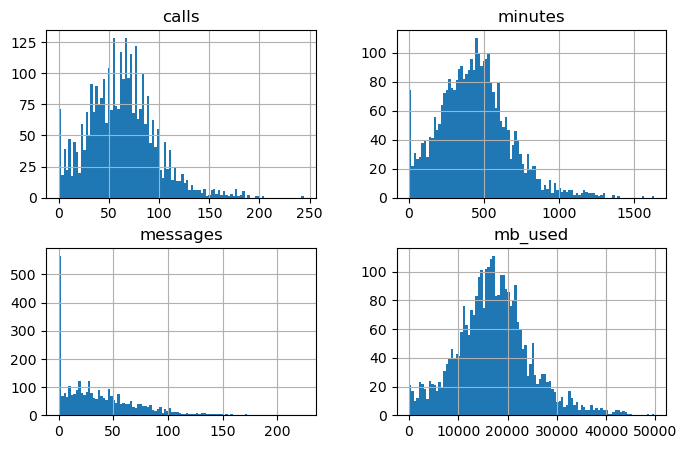

In [6]:
df.drop('is_ultra', axis=1).hist(figsize=(8, 5), bins=100);


In [7]:
# медиана для фичей
df.quantile()

calls          62.000
minutes       430.600
messages       30.000
mb_used     16943.235
is_ultra        0.000
Name: 0.5, dtype: float64

Рассмотрим ящики с усами для переменных calls и messages, если строить ящики с усами для всех сразу, то из-за разности масштабов сложно будет проанализировать рисунки.

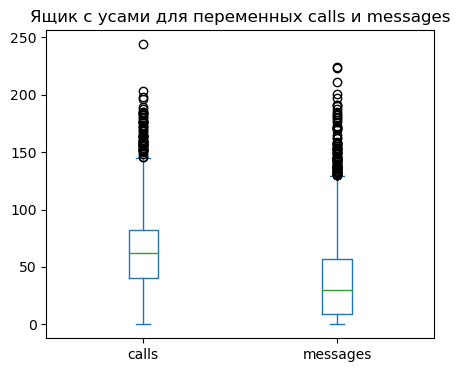

In [8]:
plt.rcParams['figure.figsize'] = (5, 4)
df.drop(['is_ultra', 'mb_used', 'minutes'], axis=1).plot(kind='box')
plt.title('Ящик с усами для переменных calls и messages');


Видим, что Q2 для calls = 62 и для messages = 30

Text(0.5, 1.0, 'Ящик с усами для mb_used')

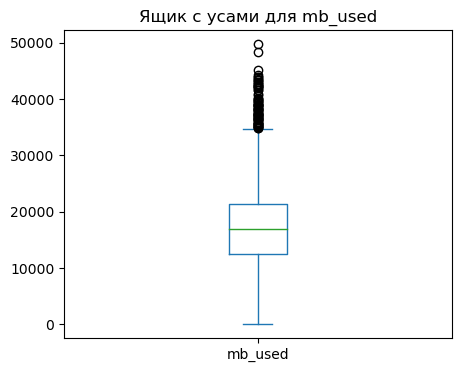

In [9]:
plt.rcParams['figure.figsize'] = (5, 4)
df['mb_used'].plot(kind='box')
plt.title('Ящик с усами для mb_used')

**Q2 для messages = 16943.235**

Text(0.5, 1.0, 'Ящик с усами для minutes')

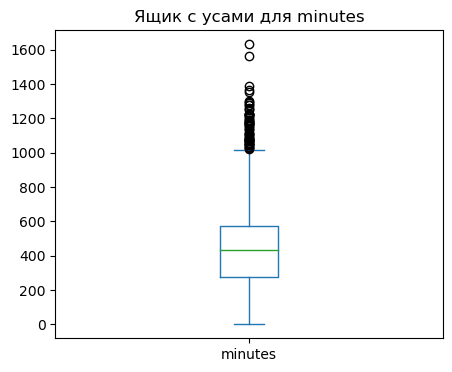

In [10]:
plt.rcParams['figure.figsize'] = (5, 4)
df['minutes'].plot(kind='box')
plt.title('Ящик с усами для minutes')

**Q2 для minutes = 430**

In [11]:
df.quantile(0.5)

calls          62.000
minutes       430.600
messages       30.000
mb_used     16943.235
is_ultra        0.000
Name: 0.5, dtype: float64

**Посчитаем межквартильные размахи и избавимся от выбросов с помощью формулы** $$(Q1 - 1.5 \cdot IQR,\ \ Q3 + 1.5 \cdot IQR)$$

Все, что за ее пределами будем считать выбросами!

In [12]:
# X = df.drop('is_ultra', axis=1)
# X.shape

In [13]:
# Q1 = X.quantile(0.25)
# Q3 = X.quantile(0.75)
# IQR = Q3 - Q1
# IQR

In [14]:
# df_clean = df[~((X < (Q1 - 1.5 * IQR)) |(X >(Q3 + 1.5 * IQR))).any(axis=1)]
df_clean = df.copy(deep=True)

In [15]:
# df_clean.shape

In [16]:
# df.shape

In [17]:
# 208/3214

**Удалили 6.4% данных**. В теории, идеальный случай, когда при предобработке мы теряем менее 5% данных. Если более 10% - уже большие потери. 

# Разбиваем выборку на train и test

Разделю датасет на 2 выборки, на train проведу EDA

In [18]:
train, test = train_test_split(df_clean, test_size=0.2, stratify=df_clean['is_ultra'], random_state=42)

**Добавим параметр stratify**, чтобы разбивка в выборки попала с соотношением целевого признака. 

Разбиваю на train и test, на train буду использовать кросс-валидацию для нахождения лучших параметров.

In [19]:
X = df_clean.drop('is_ultra', axis=1)
y = df_clean['is_ultra']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2571, 4), (643, 4), (2571,), (643,))

<div class="alert alert-info">
    <br /> 
    <font size="3", color = "black">
<br /> Разделил выборки, на train проведу EDA

# Исследовательский анализ данных

## Общая информация

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2571 entries, 576 to 500
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     2571 non-null   float64
 1   minutes   2571 non-null   float64
 2   messages  2571 non-null   float64
 3   mb_used   2571 non-null   float64
 4   is_ultra  2571 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 120.5 KB


## Анализ фичей

<div class="alert alert-info">
    <br /> 
    <font size="3", color = "black">
<br /> Также понял, что мы не должны рассматривать доли классов на всем датасете. В целом анализ можем проводить только на train 

Посмотрим как расположились доли классов. Чтобы понять **сбалансированная ли у нас выборка**:

Text(0.5, 1.0, 'Распределение по количествам классов')

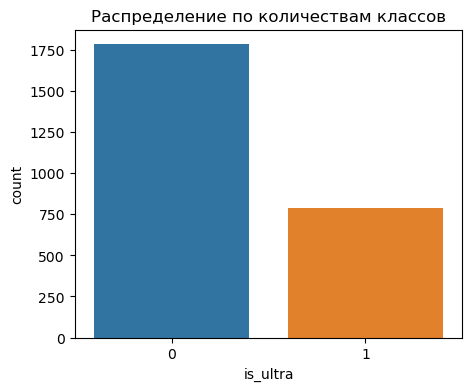

In [23]:
plt.rcParams['figure.figsize'] = (5, 4)
sns.countplot(x='is_ultra', data=train)
plt.title('Распределение по количествам классов')

In [24]:
train['is_ultra'].mean()

0.30649552703228317

Выборка не сбалансированна, смещение в сторону 0 класса. 30% - 1 класс, 70% - 0 класс.
1 класс - тариф ультра, 0 класс - тариф смарт

Посмотрим парные корреляции, на зависимости переменных.

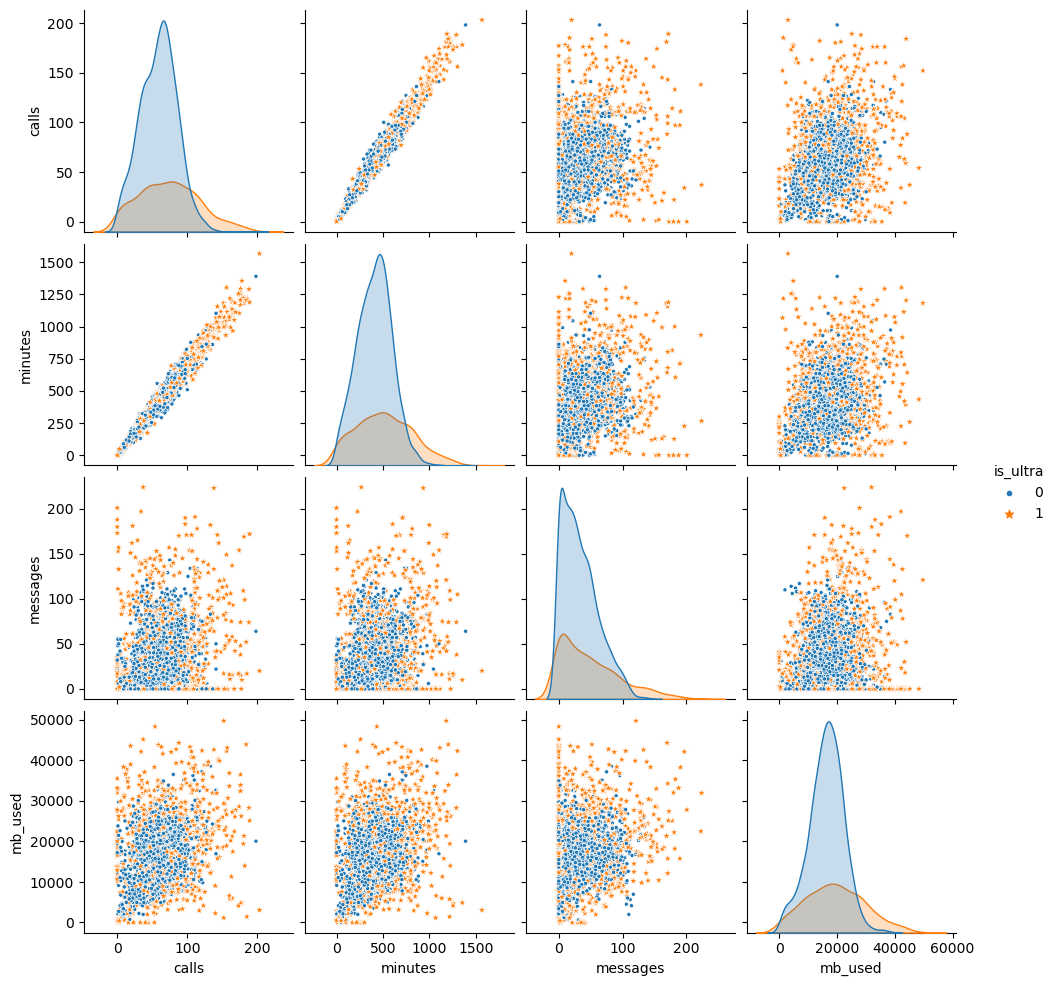

In [25]:
sns.pairplot(data=train, hue='is_ultra', markers=[".", "*"])

 Видим, что **минуты и звонки имеют линейную сильную корреляцию**. Рассчитаем ее:

In [26]:
train['minutes'].corr(train['calls'])

0.9817593256967734

Корреляция очень высокая. **Необходимо удалить один из признаков, чтобы не возникла проблема мультиколлинеарности.** Посмотрим с помощью другого коэффицента корреляции phik, выявляющий и нелинейные взаимосвязи, что влияет сильнее всего на целевую переменную, и уже исходя из этого решим, что удалить calls или minutes:

In [27]:
phik = phik.phik_matrix(train)

interval columns not set, guessing: ['calls', 'minutes', 'messages', 'mb_used', 'is_ultra']


In [28]:
phik['is_ultra'].sort_values(ascending=False)

is_ultra    1.000000
mb_used     0.481881
calls       0.472954
minutes     0.464020
messages    0.363573
Name: is_ultra, dtype: float64

minutes имеет чуть меньшее влияние, чем calls, уберем его из выборки.

In [29]:
X = df_clean.drop(['is_ultra', 'minutes'], axis=1)
y = df_clean['is_ultra']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [31]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2571, 3), (643, 3), (2571,), (643,))

# Масштабирование данных

Для моделей, основанных на расстояниях - knn, логистическая регрессия **важно масштабировать данные** (нормализовать), чтобы фичи с большими значениями не перетягивали все внимание на себя.

Деревьям решений, бэггингам и бустингам, основанных на деревьях нормализация не нужна!

<div class="alert alert-info">
    <br /> 
    <font size="3", color = "black">
<br /> Лучше отдельно создавать объект MinMaxScaler в Pipeline, чтобы избежать утечки данных

In [32]:
# mms = MinMaxScaler()
# mms.fit(X_train)

In [33]:
# X_train_norm = pd.DataFrame(mms.transform(X_train), columns=X_train.columns)
# X_train_norm


**Нормализуем тестовую выборку. Здесь на ней уже не нужно обучать.**

In [34]:
# X_test_norm = pd.DataFrame(mms.transform(X_test), columns=X_test.columns)
# X_test_norm

# Baseline

Создадим модель, и посчитаем ее качество. **Дальнейшие модели должны показать лучшие значения для качества, превосходя baseline.** В этом и заключается проверка модели на адекватность.

Зададим константное предсказание, проставим все 0.

In [35]:
pred_train = [0 for i in range(len(X_train))]
accuracy_train = accuracy_score(pred_train, y_train)

pred_test = [0 for i in range(len(X_test))]
accuracy_test = accuracy_score(pred_test, y_test)

print(f'Accuracy Baseline на train: {accuracy_train}')
print(f'Accuracy Baseline на test: {accuracy_test}')

Accuracy Baseline на train: 0.6935044729677169
Accuracy Baseline на test: 0.6936236391912908


In [36]:
accuracy_score(y_test, pred_test)

0.6936236391912908

**Наша задача побить качество на Baseline 0.69**

# Построение моделей

## Модель на основе Дерева решений (DecisionTree)

In [37]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, StratifiedKFold

**Простая модель без настроек**

In [38]:
# model_tree = DecisionTreeClassifier(random_state=42, max_depth=5)
# model_tree.fit(X_train, y_train)

# acc_train = accuracy_score(model_tree.predict(X_train), y_train)
# acc_test = accuracy_score(model_tree.predict(X_test), y_test)

# print('Качество на train:', acc_train)
# print('Качество на test:', acc_test)

**Применяем кросс-валидацию + подбор параметров**

In [39]:
%%time

# поиграемся с GridSEarchCV

parameters = {'max_depth' : range(2, 8),
             'min_samples_leaf' : range(1, 6),
             'max_leaf_nodes' : range(2, 6)}


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tree = DecisionTreeClassifier(random_state=10)
grid = GridSearchCV(tree, parameters, cv=skf, refit=True)
grid.fit(X_train, y_train)


CPU times: total: 3.03 s
Wall time: 3.03 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=10),
             param_grid={'max_depth': range(2, 8),
                         'max_leaf_nodes': range(2, 6),
                         'min_samples_leaf': range(1, 6)})

In [40]:
score(grid, 'decision_tree_best', X_test, y_test)

Accuracy на кросс-валидации: 0.7880321861659929
Accuracy на test: 0.8009331259720062


Нашли лучшие параметры и лучшую модель на кросс-валидации. 

<div class="alert alert-info">
    <br /> 
    <font size="3", color = "black">
<br /> 
        
        Добавив refit=True в GSС лучшая обученная модель будет лежать grid.best_estimator_, а затем на нем получает предикт grid.best_estimator_.predict

### Интерпретация модели дерева решений

Отрисуем дерево решений, чтобы интерпретировать модель.

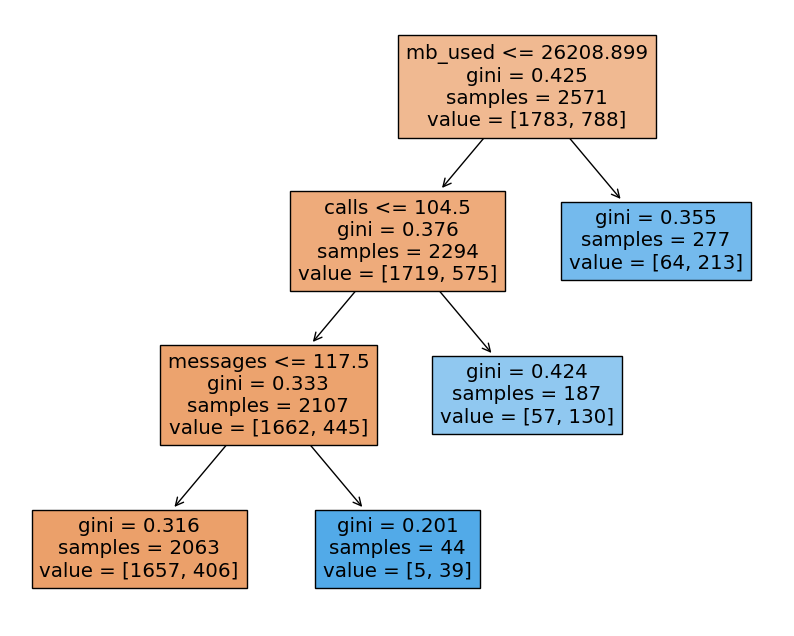

In [41]:
plt.rcParams['figure.figsize'] = (10, 8)
plot_tree(grid.best_estimator_, feature_names=X_test.columns, filled=True);


**Видим, что дерево решений работало только с calls и mb_used. messages он посчитал неважным. Видим, что по критерию gini в качестве корня дерево решений выбрало переменную calls.**

## Модель на основе Случайного леса (Random Forest)

**Построим 4 модели на основе Случайного леса:**
- 1 модель случайный лес с подбором параметров
- 2 модель случайный лес с подбором параметров + SMOTE
- 3 модель случайный лес с подбором параметров + ADASYN
- 4 модель случайный лес с подбором параметров + TomekLinks

**Обучаю модель c кросс-валидацией + подбор параметров**

In [42]:
%%time

# сначала инициализируем параметры, по которым хотим сделать полный перебор 
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

parameters = {
              'min_samples_leaf': range(3, 6),
              'max_depth': range(5, 8),
              'max_features' : range(2, 4),
            'n_estimators' : [100, 150, 200]}

# создаем модель

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rfc = RandomForestClassifier(random_state=42,
                            n_jobs=-1, oob_score=True, class_weight='balanced')


gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, refit=True)

gcv.fit(X_train, y_train)

CPU times: total: 1.69 s
Wall time: 25.4 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(5, 8), 'max_features': range(2, 4),
                         'min_samples_leaf': range(3, 6),
                         'n_estimators': [100, 150, 200]})

In [43]:
gcv.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=7, max_features=2,
                       min_samples_leaf=3, n_estimators=200, n_jobs=-1,
                       oob_score=True, random_state=42)

In [44]:
score(gcv, 'RandomForest_best', X_test, y_test)

Accuracy на кросс-валидации: 0.8035865664311889
Accuracy на test: 0.8227060653188181


### UnderSampling и OverSampling

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### SMOTE/TomekLinks

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [47]:
parameters = {'classifier__max_features': [2, 4],
              'classifier__min_samples_leaf': range(2, 7),
              'classifier__max_depth': range(5, 8),
              'classifier__n_estimators' : [100, 120]
            }


smote = SMOTE(random_state = 11)
X_train, y_train = smote.fit_resample(X_train, y_train)
pipeline = Pipeline(steps = [['classifier', RandomForestClassifier(random_state=42, n_jobs=-1)]])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gcv = GridSearchCV(pipeline, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[['classifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42)]]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': range(5, 8),
                         'classifier__max_features': [2, 4],
                         'classifier__min_samples_leaf': range(2, 7),
                         'classifier__n_estimators': [100, 120]},
             verbose=1)

In [48]:
gcv.best_estimator_

Pipeline(steps=[['classifier',
                 RandomForestClassifier(max_depth=7, max_features=2,
                                        min_samples_leaf=6, n_estimators=120,
                                        n_jobs=-1, random_state=42)]])

In [49]:
score(gcv, 'RF_SMOTE', X_test, y_test)

Accuracy на кросс-валидации: 0.7490180363870653
Accuracy на test: 0.7962674961119751


**OverSampling с помощью ADASYN**

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [51]:
parameters = {'classifier__max_features': [2, 4],
              'classifier__min_samples_leaf': range(2, 7),
              'classifier__max_depth': range(5, 8),
              'classifier__n_estimators' : [100, 120]
            }


ada = ADASYN(random_state = 11)
X_train, y_train = ada.fit_resample(X_train, y_train)
pipeline = Pipeline(steps = [['classifier', RandomForestClassifier(random_state=42, n_jobs=-1)]])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gcv = GridSearchCV(pipeline, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[['classifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42)]]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': range(5, 8),
                         'classifier__max_features': [2, 4],
                         'classifier__min_samples_leaf': range(2, 7),
                         'classifier__n_estimators': [100, 120]},
             verbose=1)

In [52]:
gcv.best_estimator_

Pipeline(steps=[['classifier',
                 RandomForestClassifier(max_depth=7, max_features=2,
                                        min_samples_leaf=2, n_jobs=-1,
                                        random_state=42)]])

In [53]:
score(gcv, 'RF_ADASYN', X_test, y_test)

Accuracy на кросс-валидации: 0.7017375314586694
Accuracy на test: 0.7776049766718507


**under_sampling с помощью TomekLinks**

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [55]:
parameters = {'classifier__max_features': [2, 4],
              'classifier__min_samples_leaf': range(2, 7),
              'classifier__max_depth': range(5, 8),
              'classifier__n_estimators' : [100, 120]
            }


TomekLinks = TomekLinks()
X_train, y_train = TomekLinks.fit_resample(X_train, y_train)
pipeline = Pipeline(steps = [['classifier', RandomForestClassifier(random_state=42, n_jobs=-1)]])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gcv = GridSearchCV(pipeline, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[['classifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42)]]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': range(5, 8),
                         'classifier__max_features': [2, 4],
                         'classifier__min_samples_leaf': range(2, 7),
                         'classifier__n_estimators': [100, 120]},
             verbose=1)

In [56]:
gcv.best_estimator_

Pipeline(steps=[['classifier',
                 RandomForestClassifier(max_depth=7, max_features=2,
                                        min_samples_leaf=3, n_estimators=120,
                                        n_jobs=-1, random_state=42)]])

In [57]:
score(gcv, 'RF_TomekLinks', X_test, y_test)

Accuracy на кросс-валидации: 0.8125551854319342
Accuracy на test: 0.8118195956454122


In [58]:
score_models

,accuracy_test,accuracy на кросс-валидации
decision_tree_best,0.800933,0.788032
RandomForest_best,0.822706,0.803587
RF_SMOTE,0.796267,0.749018
RF_ADASYN,0.777605,0.701738
RF_TomekLinks,0.811820,0.812555



## Модель на основе Логистической регрессии (Logistic Regression)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [60]:
parameters = {'model__C' : [0.8, 0.9, 0.1],
             'model__class_weight' : ['balanced', None],
             'model__warm_start' : [True, False]}

pipe = Pipeline([('scaler', MinMaxScaler()), ('model', LogisticRegression())])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid=parameters, cv=skf, refit=True)

grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('model', LogisticRegression())]),
             param_grid={'model__C': [0.8, 0.9, 0.1],
                         'model__class_weight': ['balanced', None],
                         'model__warm_start': [True, False]})

In [61]:
score(grid, 'LogisticRegression_best', X_test, y_test)

Accuracy на кросс-валидации: 0.7432987042423784
Accuracy на test: 0.7371695178849145


<div class="alert alert-info">
    <br /> 
    <font size="3", color = "black">
<br /> 
        
        1) Метрика на train была выше, чем на валидации, получили переобучение. 
        
        
        2) Ошибка на ансамблях состоит E = шум + variance + bias. C шумом мы ничего не сделаем, bias у нас не меняется, а вот ошибку на дисперсии рассматриваем подробнее она состоит из ((разброс базового алгоритма) / количество моделей) + корреляция между базовыми алгоритмами. Первую составляющую мы у variance уеньшаем количеством моделей, а вторую - корреляцию между базовыми алгоритмами уменьшаем с помощью метода случайных подпространств. В итоге, лучшее качество достигается за счет бэггинга (используя бутстрэп) + уменьшения корреляции (методом случайных подпространств). 
        






## Модель на основе K-ближайших соседей

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

parameters = {'model__n_neighbors' : range(3, 7),
              'model__weights' : ['uniform', 'distance']
             }

pipe = Pipeline([('scaler', MinMaxScaler()), ('model', KNeighborsClassifier())])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid=parameters, cv=skf, refit=True)

grid.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': range(3, 7),
                         'model__weights': ['uniform', 'distance']})

In [63]:
gcv.best_params_

{'classifier__max_depth': 7,
 'classifier__max_features': 2,
 'classifier__min_samples_leaf': 3,
 'classifier__n_estimators': 120}

In [64]:
score(grid, 'KNN_best', X_test, y_test)

Accuracy на кросс-валидации: 0.7946318612821578
Accuracy на test: 0.7962674961119751


### UnderSampling и OverSampling в KNN

Построим 4 модели на основе KNN:
- 1 модель KNN с подбором параметров
- 2 модель KNN с подбором параметров + SMOTE
- 3 модель KNN с подбором параметров + ADASYN
- 4 модель KNN с подбором параметров + TomekLinks


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

**OverSampling с помощью SMOTE + нормализация**

In [66]:
parameters = {'classifier__n_neighbors' : range(3, 7),
              'classifier__weights' : ['uniform', 'distance']
             }


smote = SMOTE(random_state = 11)
X_train, y_train = smote.fit_resample(X_train, y_train)
pipeline = Pipeline(steps = [['scaler', MinMaxScaler()],['classifier', KNeighborsClassifier( n_jobs=-1)]])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gcv = GridSearchCV(pipeline, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[['scaler', MinMaxScaler()],
                                       ['classifier',
                                        KNeighborsClassifier(n_jobs=-1)]]),
             n_jobs=-1,
             param_grid={'classifier__n_neighbors': range(3, 7),
                         'classifier__weights': ['uniform', 'distance']},
             verbose=1)

In [67]:
gcv.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ['classifier',
                 KNeighborsClassifier(n_jobs=-1, n_neighbors=6,
                                      weights='distance')]])

In [68]:
score(gcv, 'KNN_SMOTE', X_test, y_test)

Accuracy на кросс-валидации: 0.726018991046629
Accuracy на test: 0.7511664074650077


**OverSampling с помощью ADASYN + нормализация**

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [70]:
parameters = {'classifier__n_neighbors' : range(3, 7),
              'classifier__weights' : ['uniform', 'distance']
             }


adasyn = ADASYN(random_state = 11)
X_train, y_train = adasyn.fit_resample(X_train, y_train)
pipeline = Pipeline(steps = [['scaler', MinMaxScaler()],['classifier', KNeighborsClassifier( n_jobs=-1)]])


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gcv = GridSearchCV(pipeline, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[['scaler', MinMaxScaler()],
                                       ['classifier',
                                        KNeighborsClassifier(n_jobs=-1)]]),
             n_jobs=-1,
             param_grid={'classifier__n_neighbors': range(3, 7),
                         'classifier__weights': ['uniform', 'distance']},
             verbose=1)

In [71]:
gcv.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ['classifier',
                 KNeighborsClassifier(n_jobs=-1, weights='distance')]])

In [72]:
score(gcv, 'KNN_ADASYN', X_test, y_test)

Accuracy на кросс-валидации: 0.6897411623540044
Accuracy на test: 0.6858475894245724


## Модель на основе Catboost (Градиентный бустинг)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

**Перенесем данные в объекты Pool CatBoost**

In [74]:
train_data = Pool(data=X_train,
                 label=y_train)

test_data = Pool(data=X_test,
                label=y_test)

### Подбор гиперпараметров

In [75]:
params = {'verbose' : 100,
          'random_seed' : 42,
         'loss_function' : 'Logloss',
         'verbose' : False}


model_new = CatBoostClassifier(**params)

grid = {'learning_rate': [0.015, 0.020],
        'depth': [4, 5, 6, 7]}
    
result = model_new.grid_search(grid, train_data, cv=5,
                               partition_random_seed=42,
                               shuffle=True, stratified=True,
                               verbose=False, plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.4226280771
bestIteration = 998


bestTest = 0.4238920991
bestIteration = 993


bestTest = 0.4213970797
bestIteration = 978


bestTest = 0.4193882863
bestIteration = 999


bestTest = 0.4179799154
bestIteration = 678


bestTest = 0.4182223136
bestIteration = 791


bestTest = 0.4195660289
bestIteration = 604


bestTest = 0.4195431427
bestIteration = 591

Training on fold [0/5]

bestTest = 0.4668673644
bestIteration = 510

Training on fold [1/5]

bestTest = 0.4371389946
bestIteration = 766

Training on fold [2/5]

bestTest = 0.4785237295
bestIteration = 357

Training on fold [3/5]

bestTest = 0.4390538163
bestIteration = 626

Training on fold [4/5]

bestTest = 0.3981007637
bestIteration = 931



In [76]:
print('Best parameters: {}\n'.format(result['params']))


Best parameters: {'depth': 6, 'learning_rate': 0.015}



In [77]:
# теперь, зная этот гиперпараметр давай обучим модель

params = {'learning_rate' : 0.015,
         'verbose' : 100,
         'random_seed' : 42,
         'loss_function' : 'Logloss',
         'depth' : 7}

model_best_catboost = CatBoostClassifier(**params)

model_best_catboost.fit(train_data)

0:	learn: 0.6863122	total: 2.73ms	remaining: 2.73s
100:	learn: 0.4626840	total: 250ms	remaining: 2.22s
200:	learn: 0.4251013	total: 496ms	remaining: 1.97s
300:	learn: 0.4079247	total: 727ms	remaining: 1.69s
400:	learn: 0.3956432	total: 954ms	remaining: 1.43s
500:	learn: 0.3834674	total: 1.18s	remaining: 1.18s
600:	learn: 0.3702981	total: 1.41s	remaining: 937ms
700:	learn: 0.3569437	total: 1.64s	remaining: 700ms
800:	learn: 0.3434294	total: 1.87s	remaining: 465ms
900:	learn: 0.3312870	total: 2.12s	remaining: 233ms
999:	learn: 0.3190816	total: 2.34s	remaining: 0us


In [78]:
acc_train = accuracy_score(model_best_catboost.predict(train_data), y_train)
acc_test = accuracy_score(model_best_catboost.predict(test_data), y_test)

In [79]:

print('Качество на train: ', acc_train)
print('Качество на test: ', acc_test)

Качество на train:  0.8716452742123687
Качество на test:  0.8227060653188181


**Занесем результаты в таблицу**

In [80]:

    
score_models.loc[len(score_models.index)] = [acc_test, acc_train]
score_models.rename(index={(len(score_models.index)-1): 'model_best_catboost'}, inplace=True)


### Интерпретация результатов модели

In [81]:
import shap
shap.initjs()

In [82]:
# теперь рассчитаем shap_values

explainer = shap.TreeExplainer(model_best_catboost)
shap_values = explainer.shap_values(X_test)

In [83]:
shap_values

array([[-0.97586084,  0.10513626,  0.07815661],
       [ 1.09058141,  0.60738207, -0.4679956 ],
       [-0.0642818 ,  0.38670732,  2.07629551],
       ...,
       [-0.74412464,  0.33330268, -0.98911351],
       [-0.01266525,  1.15535508,  1.21624566],
       [-0.11810359,  1.09863945, -0.64562463]])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


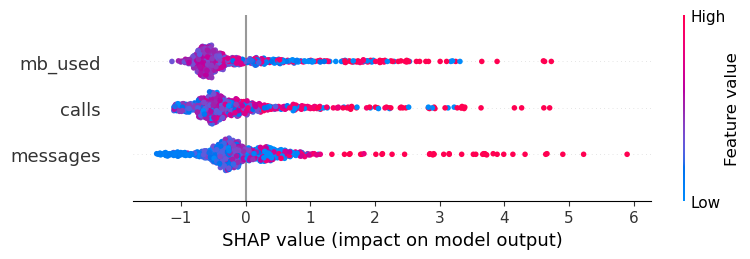

In [84]:
# начнем анализ с построения summary_plot

shap.summary_plot(shap_values, X_test)

# передаем ему shap_values и сами данные по фичам

**Видим, что модель предсказывает бОльший score при больших значениях messages**

In [85]:
# В catboost можно понять какая фича для модели ВАЖНЕЕ ВСЕГО

model_best_catboost.get_feature_importance(prettified=True)

,Feature Id,Importances
0,mb_used,34.749499
1,calls,34.642859
2,messages,30.607642


**mb_used - фича, обладающая наибольшей важностью для модели**

# Сравнение результатов моделей

**Рассмотрим таблицу качества моделей**

In [86]:
score_models.sort_values(by='accuracy_test', ascending=False)

,accuracy_test,accuracy на кросс-валидации
RandomForest_best,0.822706,0.803587
model_best_catboost,0.822706,0.871645
RF_TomekLinks,0.811820,0.812555
decision_tree_best,0.800933,0.788032
RF_SMOTE,0.796267,0.749018
KNN_best,0.796267,0.794632
RF_ADASYN,0.777605,0.701738
KNN_SMOTE,0.751166,0.726019
LogisticRegression_best,0.737170,0.743299
KNN_ADASYN,0.685848,0.689741


**Лучший accuracy - 0.82** на случайном лесе

# Вывод

В нашем распоряжении были **данные о поведении клиентов**, которые уже перешли на новые тарифы. Задача - построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф "Смарт" или "Ультра".

**В данном проекте построили 12 моделей:**
- Дерево решений
- Случаный лес 
- Случайный лес + SMOTE
- Случайный лес + ADASYN
- Случайный лес + TomekLinks
- KNN
- KNN  + SMOTE
- KNN  + ADASYN
- KNN + TomekLinks
- CatBoostClassifier

На каждой модели использовалась кросс-валидация, применялась стратификация, в моделях, работающих на расстояних использовали масштабирование данных. Из 4 начальных фичей оставили только 3. Поскольку calls и minutes имели высокую корреляцию и могли бы вызвать **проблему мультиколлинеарности**. 

**Лучший accuracy - 0.82** на случайном лесе

**Если очистку данных в начале не делать, то результаты становятся лучше. **

Также была проведена **интерпретация моделей**, большинство из них отдавала **предпочтение классу 1 при бОльшем** расховании **mb_used.**

**Baseline пробили все модели**